<a href="https://colab.research.google.com/github/IA2021UR/trabajo-ia-en-la-comunidad-de-la-rioja-equipo-4/blob/main/comparacion_modelos.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Comparativa de modelos


In [ ]:
!pip install visualkeras
import visualkeras

In [19]:
model = gan
visualkeras.layered_view(model).show() # display using your system viewer
visualkeras.layered_view(model, to_file='output.png') # write to disk
visualkeras.layered_view(model, to_file='output.png').show() # write and show

In [1]:
!wget --no-check-certificate https://ferminjimenez.com/data/images.zip -O images.zip
!unzip -qq images.zip

In [ ]:
from keras.models import Model
from keras.layers import InputLayer, Conv2D,concatenate, Concatenate, MaxPooling2D, Activation, BatchNormalization,MaxPool2D, UpSampling2D, Dropout, Flatten, Dense, Input, LeakyReLU, Conv2DTranspose, AveragePooling2D
from keras.optimizers import Adam
from keras.models import Sequential
import keras.models as models
from sklearn.model_selection import train_test_split
import cv2
import matplotlib.pyplot as plt
import numpy as np
from glob import glob
from PIL import Image
import random
from skimage import color, io
import tensorflow as tf
from keras import backend as K
sess = tf.compat.v1.Session(config=tf.compat.v1.ConfigProto(log_device_placement=True))
tf.config.list_physical_devices('GPU')

# Funciones

In [29]:
def rgb_to_lab(image, l=False, ab=False):
  l_channel = color.rgb2lab(image)[:,:,0]
  l_channel = l_channel[...,np.newaxis]

  ab_channels = color.rgb2lab(image)[:,:,1:]
  if l:
      return l_channel
  else: return ab_channels

def rgb_to_lab_norm(image, l=False, ab=False):
  l_channel = color.rgb2lab(image)[:,:,0]
  l_channel = l_channel[...,np.newaxis]
  l_channel = normalize_array(l_channel, 100)

  ab_channels = color.rgb2lab(image)[:,:,1:]

  ab_channels = ab_channels
  ab_channels = normalize_array(ab_channels, 127)
  if l:
      return l_channel
  else: return ab_channels

def to_gray_scale(image):
  return cv2.cvtColor(image.copy(), cv2.COLOR_BGR2GRAY)

def to_rgb(image):
  return cv2.cvtColor(image.copy(), cv2.COLOR_GRAY2RGB)

def load_resize(file):
  f = cv2.imread(file)
  f = cv2.cvtColor(f, cv2.COLOR_BGR2RGB)
  return cv2.resize(f, (256, 256))

def normalize_array(arr, n = 255):
  return arr / n * 2 - 1 # normalize to [-1, 1]

def de_normalize_array(arr, n = 255):
  recovered = (arr - arr.min()) * n / (arr.max() - arr.min())
  recovered = np.rint(recovered).astype(np.uint8) # round before casting
  return recovered

def load_resize_normalized_lab(file):
  image = cv2.imread(file)
  image = cv2.resize(image, (256, 256))
  scaled = image.astype("float32") / 255.0
  return cv2.cvtColor(scaled, cv2.COLOR_BGR2LAB)

def lab_l(image):
  img = cv2.split(image)[0]
  img -= 50
  return cv2.resize(img, (256, 256))

def lab_ab(image):
  image = cv2.resize(image, (256, 256))
  a = cv2.split(image)[1]
  b = cv2.split(image)[2]
  img = np.zeros((256, 256, 2))
  img[:,:,0] = a
  img[:,:,1] = b
  return img

def l_ab_lab(l, ab):
  return np.concatenate((l[:, :, np.newaxis], ab), axis=2)

# Models

### Discriminator

Imagen del la arquitectura del discriminador

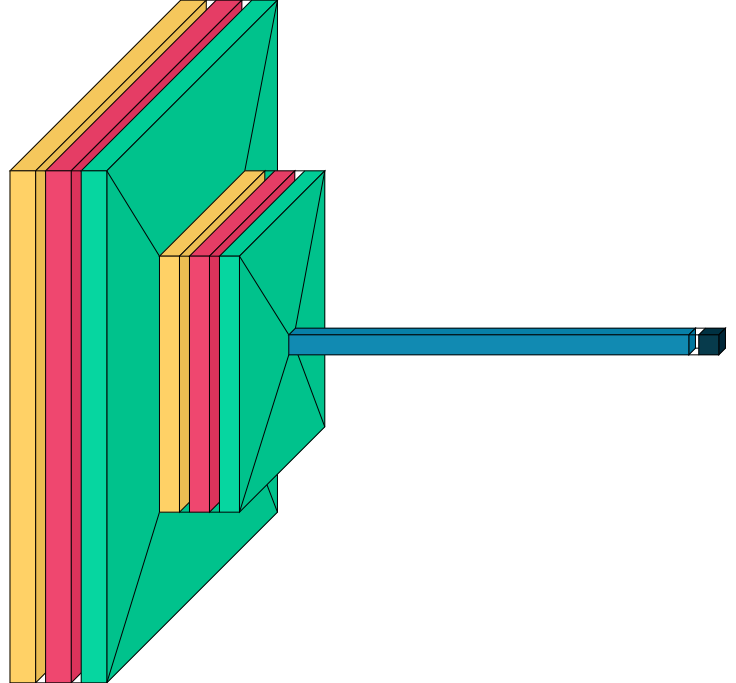

In [4]:
def build_discriminator():
  input_shape = (256,256, 2)
  model = Sequential()
  model.add(Conv2D(256, kernel_size=(5,5), strides=(2,2), padding="same" ,input_shape=input_shape))
  model.add(LeakyReLU())
  model.add(Dropout(0.3))
  model.add(Conv2D(128, kernel_size=(5,5), strides=(2,2), padding="same"))
  model.add(LeakyReLU())
  model.add(Dropout(0.3))
  model.add(Flatten())
  model.add(Dense(1, activation="sigmoid"))
  return model

def compile_discriminator(model):
  opt = Adam(lr=.0008, beta_1=0.9)
  #model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])
  model.compile(optimizer='rmsprop',loss='mse', metrics=['accuracy'])
  model.trainable = True
  return model

def save_discriminator(model):
  model.save('discriminator.h5', overwrite=True)

def load_discriminator():
  return models.load_model('discriminator.h5')

### Generator

Arquitectura del modelo *generador*

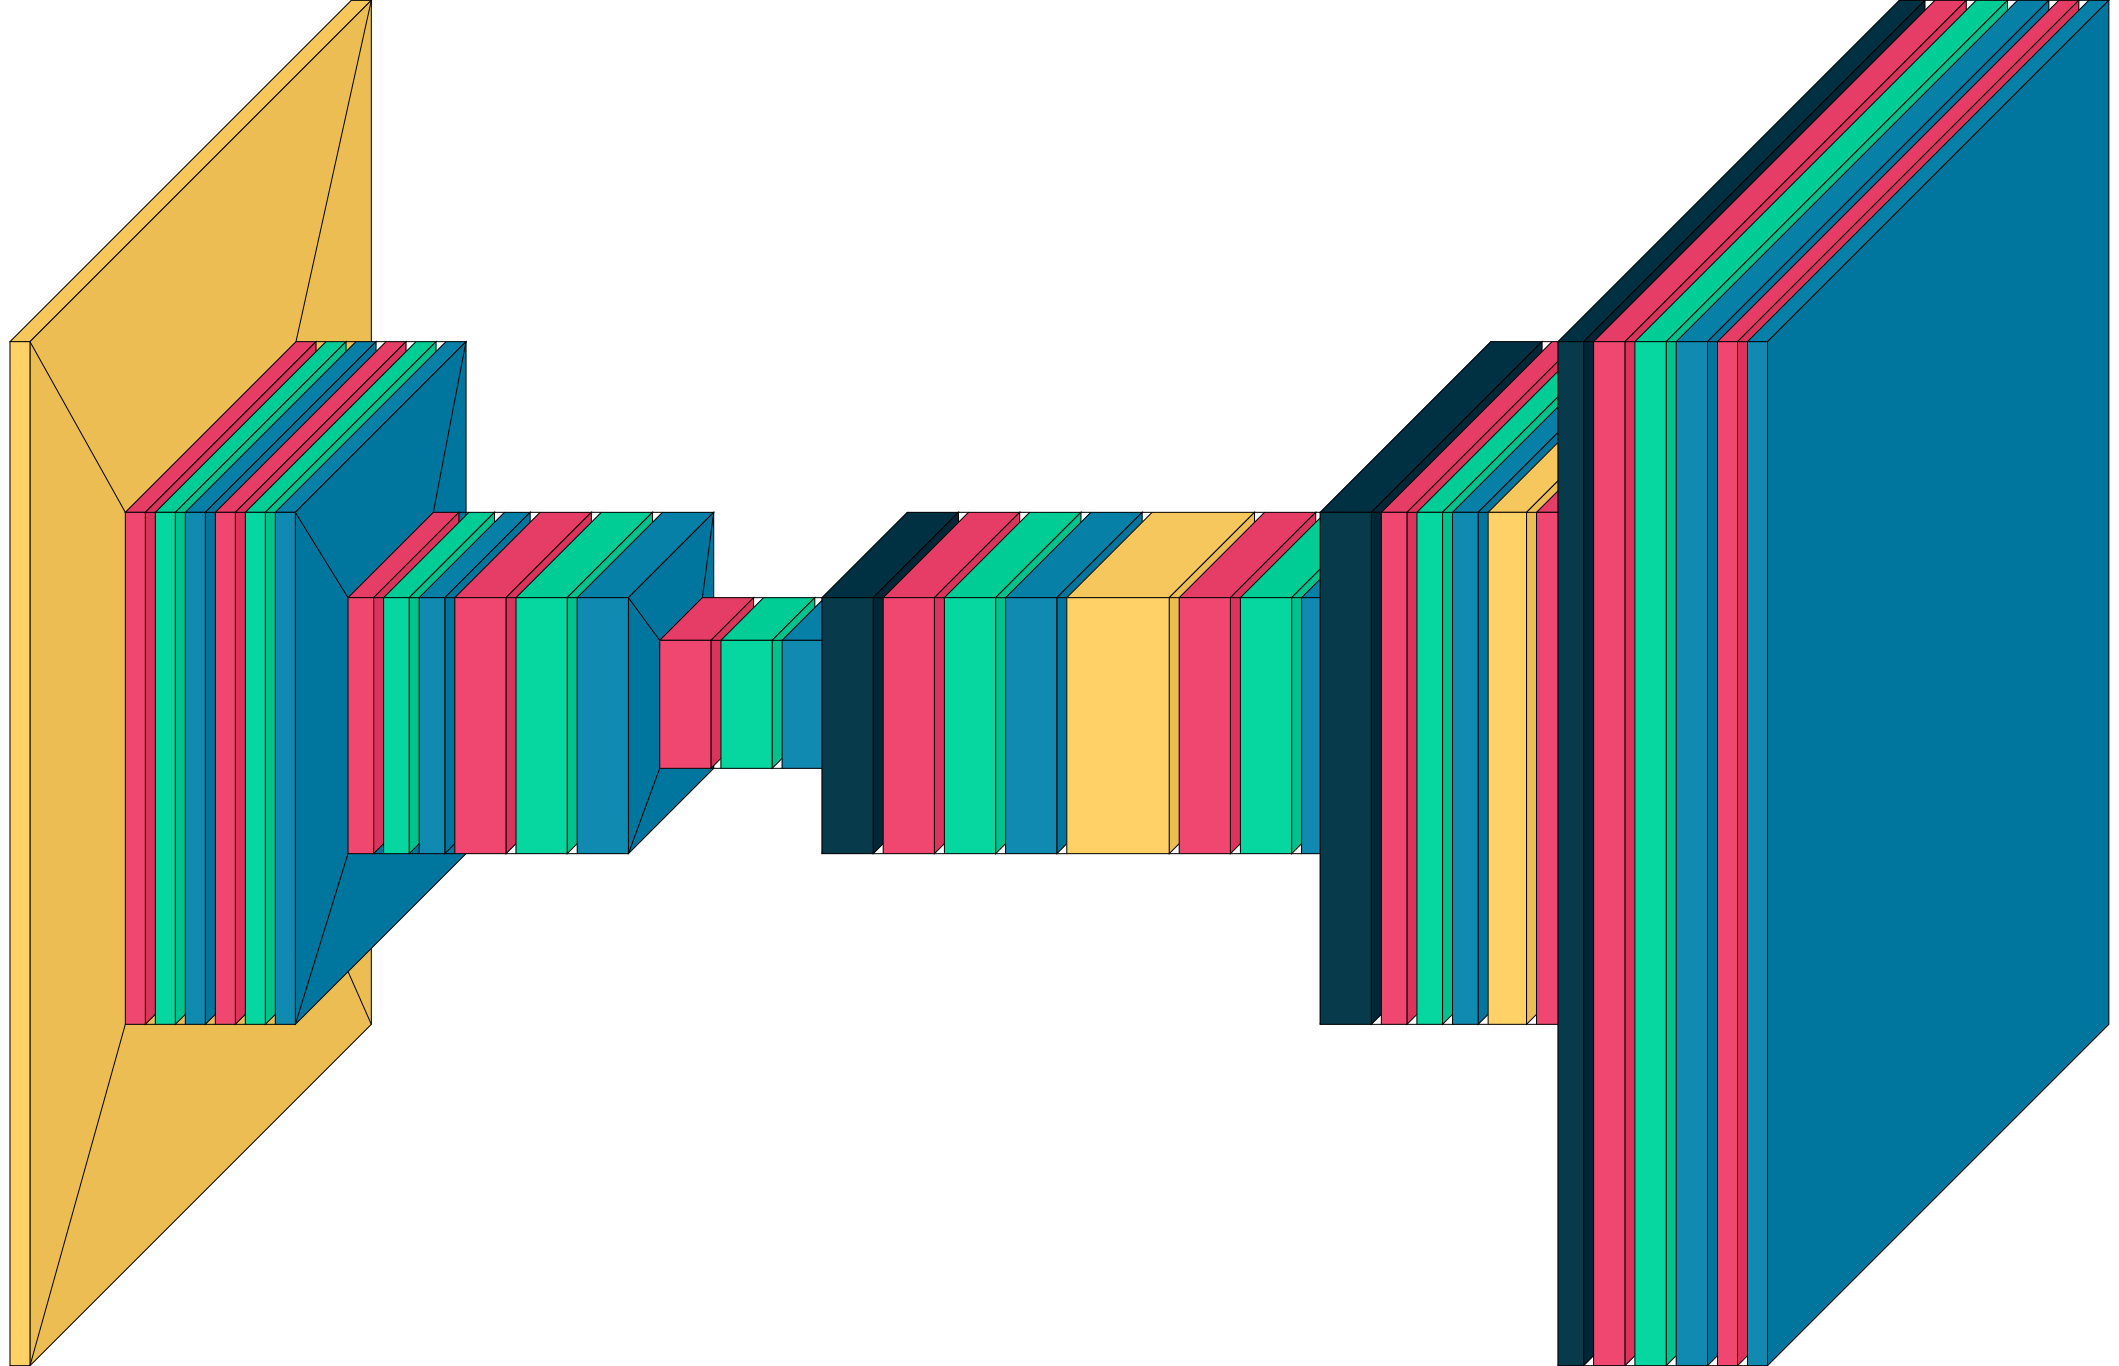

In [5]:
def build_generator():
  g_input_shape = (256,256, 1)
  g_input = Input(shape=g_input_shape)

  conv1 = Conv2D(64, (3, 3), padding='same', strides=2)(g_input)
  conv1 = BatchNormalization()(conv1)
  conv1 = Activation('relu')(conv1)

  conv2 = Conv2D(128, (3, 3), padding='same', strides=1)(conv1)
  conv2 = BatchNormalization()(conv2)
  conv2 = Activation('relu')(conv2)

  conv3 = Conv2D(256, (3, 3), padding='same', strides=2)(conv2)
  conv3 = BatchNormalization()(conv3)
  conv3 = Activation('relu')(conv3)

  conv4 = Conv2D(512, (3, 3), padding='same', strides=1)(conv3)
  conv4 = BatchNormalization()(conv4)
  conv4 = Activation('relu')(conv4)

  conv5 = Conv2D(512, (3, 3), padding='same', strides=2)(conv4)
  conv5 = BatchNormalization()(conv5)
  conv5 = Activation('relu')(conv5)

  conv7 = UpSampling2D(size=(2, 2))(conv5)
  conv7 = Conv2D(512, (3, 3), padding='same')(conv7)
  conv7 = BatchNormalization()(conv7)
  conv7 = Activation('relu')(conv7)
  conv7 = Concatenate(axis=-1)([conv7,conv4])

  conv8 = Conv2D(512, (3, 3), padding='same')(conv7)
  conv8 = BatchNormalization()(conv8)
  conv8 = Activation('relu')(conv8)

  up2 = UpSampling2D(size=(2, 2))(conv8)
  conv9 = Conv2D(256, (3,3), padding='same')(up2)
  conv9 = BatchNormalization()(conv9)
  conv9 = Activation('relu')(conv9)
  conv9 = Concatenate(axis=-1)([conv9,conv2])

  conv10 = Conv2D(256, (3, 3), padding='same')(conv9)
  conv10 = BatchNormalization()(conv10)
  conv10 = Activation('relu')(conv10)

  up3 = UpSampling2D(size=(2, 2))(conv10)
  conv11 = Conv2D(313, (1,1), padding='same')(up3)
  conv11 = BatchNormalization()(conv11)
  conv11 = Activation('relu')(conv11)

  conv12 = Conv2D(2, (1, 1), padding='same')(conv11)
  conv12 = Activation('tanh')(conv12)

  return Model(inputs=g_input,outputs=conv12)

def compile_generator(model):
  opt = Adam(lr=.0001, beta_1=0.7)
  model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])
  return model

def save_generator(model):
  model.save('generator.h5', overwrite=True)

def load_generator():
  return models.load_model('generator.h5')



### Generator UNET

Arquitectura del modelo generador UNET, no se reflejan las conexiones que se realizan entre ambos lados de la red que son tipicas de la arquitectura UNET

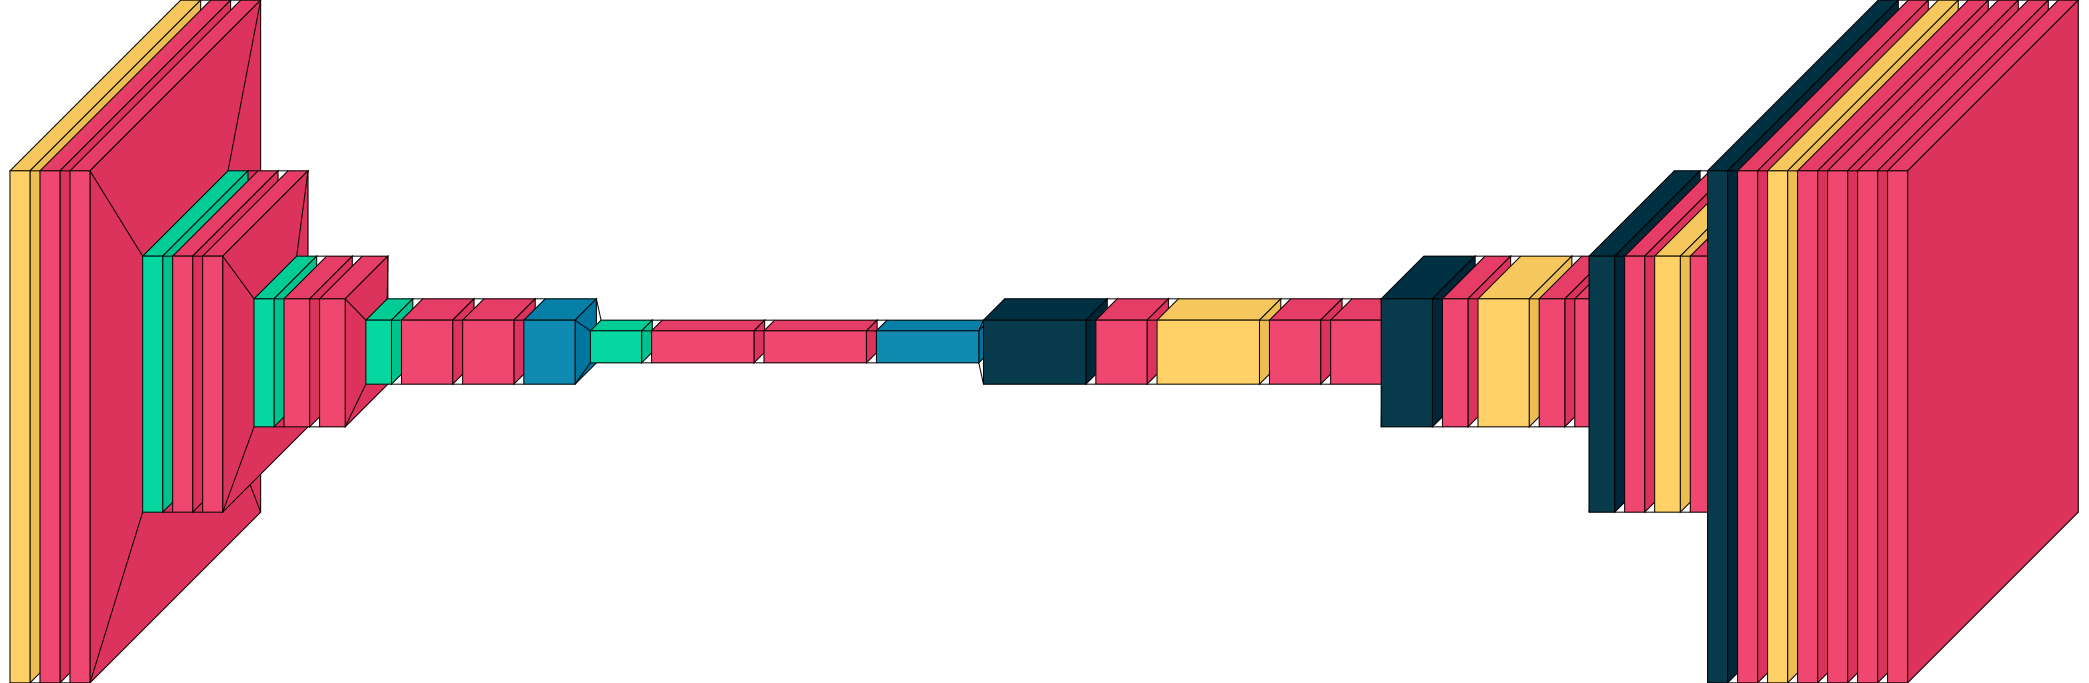

In [6]:
def build_unet():
  inputs = Input((256, 256,1))
  conv1 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(inputs)
  conv1 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv1)
  pool1 = MaxPool2D(pool_size=(2, 2))(conv1)

  conv2 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool1)
  conv2 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv2)
  pool2 = MaxPool2D(pool_size=(2, 2))(conv2)

  conv3 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool2)
  conv3 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv3)
  pool3 = MaxPool2D(pool_size=(2, 2))(conv3)

  conv4 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool3)
  conv4 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv4)
  drop4 = Dropout(0.5)(conv4)
  pool4 = MaxPool2D(pool_size=(2, 2))(drop4)

  conv5 = Conv2D(1024, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool4)
  conv5 = Conv2D(1024, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv5)
  drop5 = Dropout(0.5)(conv5)

  up6 = Conv2D(512, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(drop5))
  merge6 = concatenate([drop4,up6], axis = 3)
  conv6 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge6)
  conv6 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv6)

  up7 = Conv2D(256, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv6))
  merge7 = concatenate([conv3,up7], axis = 3)
  conv7 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge7)
  conv7 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv7)

  up8 = Conv2D(128, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv7))
  merge8 = concatenate([conv2,up8], axis = 3)
  conv8 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge8)
  conv8 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv8)

  up9 = Conv2D(64, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv8))
  merge9 = concatenate([conv1,up9], axis = 3)
  conv9 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge9)
  conv9 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv9)
  conv9 = Conv2D(2, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv9)
  conv10 = Conv2D(2, 1, activation = 'tanh')(conv9)

  model = Model(inputs,conv10)
  return model

def compile_unet(model):
  opt = Adam(lr=.002)
  #model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])
  model.compile(optimizer='rmsprop',loss='mse', metrics=['accuracy'])
  return model

def save_unet(model):
  model.save('unet.h5', overwrite=True)

def load_unet():
  return models.load_model('unet.h5')


### GAN

In [7]:
def build_gan(input_generator, model_discriminator, model_generator):
  gan_input = Input(shape=input_generator)
  generator = model_generator(gan_input)
  model_discriminator.trainable = False
  real_or_fake = model_discriminator(generator)
  gan = Model(gan_input, real_or_fake)
  opt = Adam(lr=.01, beta_1=0.5)
  #gan.compile(loss='binary_crossentropy', optimizer=opt,  metrics=['accuracy'])
  gan.compile(optimizer='rmsprop',loss='mse', metrics=['accuracy'])
  return gan

# GAN

## Grey to RGB

### Train

In [8]:
discriminator = compile_discriminator(build_discriminator())
generator = compile_generator(build_generator())
gan_generator = build_gan((256,256, 1), discriminator, generator)

In [9]:
discriminator = compile_discriminator(build_discriminator())
unet = compile_unet(build_unet())
gan_unet = build_gan((256,256, 1), discriminator, unet)

### Test

## L to LAB

### Funciones

In [15]:
def prepare_images_discriminator_lab(files, model_generator):
  
  # Se cargan todas las imagenes y se transofrman a LAB
  x_true = np.array([np.array(load_resize_normalized_lab(f)).astype('uint8') for f in files])

  # Se copian las imagenes
  x_fake = x_true.copy()

  # Se extrae el canal AB
  x_true = np.array([lab_ab(image) for image in x_true])

  # Se extra el canal L
  x_fake = np.array([lab_l(image) for image in x_fake])

  # Se usa el modelo generador para generar imagenes que se daran como malas
  # Permitiendo mejorar el modelo, se obtienen imagenes con canal AB
  x_fake_model = model_generator.predict(x_fake)

  size = len(x_fake_model)
  # Las imagenes reales con 1 y las predicciones a 0
  y_true = np.ones(len(x_true))
  y_fake = np.zeros(size)

  # Se concatenan
  x = np.concatenate((x_true, x_fake_model))
  y = np.concatenate((y_true, y_fake))

  # Se mezclan
  random.seed(44)
  random.shuffle(x)
  random.seed(44)
  random.shuffle(y)
  random.seed()
  return x, y

# Permite no cargar todas las imagenes a la vez
def batch_images_discriminator_lab(files, batch_size, model_generator):
    
    # Cantidad de ficheros
    L = len(files)

    while True:

        # Batch de inicio y fin
        batch_start = 0
        batch_end = batch_size

        while batch_start < L:
            # Se obtiene el minimo para no pasarse de indice
            limit = min(batch_end, L)

            # Se preparan las imagenes para el batch correspondiente
            X, Y = prepare_images_discriminator_lab(files[batch_start:limit], model_generator)

            # Se pasa a tensor
            X  = tf.convert_to_tensor(X, dtype=tf.float16)
            Y  = tf.convert_to_tensor(Y, dtype=tf.float16)
            yield (X,Y)

            # Se actualizan para el siguiente batch
            batch_start += batch_size   
            batch_end += batch_size


def prepare_images_gan_lab(files):

  # Se cargan las imágenes y se transforman a LAB normalizadas
  x_true = np.array([np.array(load_resize_normalized_lab(f)).astype('uint8') for f in files])
  x_true = np.array([lab_l(image) for image in x_true])
  x_true  = tf.convert_to_tensor(x_true, dtype=tf.float16)
  y_true = tf.convert_to_tensor(np.ones(len(x_true)), dtype=tf.float16)

  return x_true, y_true


def batch_images_gan_lab(files, batch_size):

    L = len(files)

    while True:

        batch_start = 0
        batch_end = batch_size

        while batch_start < L:
            limit = min(batch_end, L)
            X, Y = prepare_images_gan_lab(files[batch_start:limit])

            yield (X,Y)

            batch_start += batch_size   
            batch_end += batch_size

### Train

In [11]:
discriminator = compile_discriminator(build_discriminator())
generator = compile_generator(build_generator())
gan = build_gan((256,256, 1), discriminator, generator)

In [ ]:
file_paths = glob('./*/*.*g')
random.shuffle(file_paths)

batch_size = 8
steps_per_epoch = 16
#steps_per_epoch = len(file_paths) // batch_size
epochs = 5

batch_images_function = batch_images_discriminator_lab(file_paths, batch_size, generator)
batch_images_function_gan = batch_images_gan_lab(file_paths, batch_size)

with tf.device("/gpu:0"): 
  epoch = 0
  while epoch <= epochs:
    # Permitirmos entrenar el discriminador
    discriminator.trainable = True
    discriminator.fit(batch_images_function, steps_per_epoch=steps_per_epoch, epochs=1)
    # Bloqueamos entrenar el discriminador
    discriminator.trainable = False
    gan.fit(batch_images_function_gan, steps_per_epoch=steps_per_epoch, epochs=1)
    epoch += 1




10/16 [=================>............] - ETA: 4s - loss: 0.2937 - accuracy: 0.7063

### Test

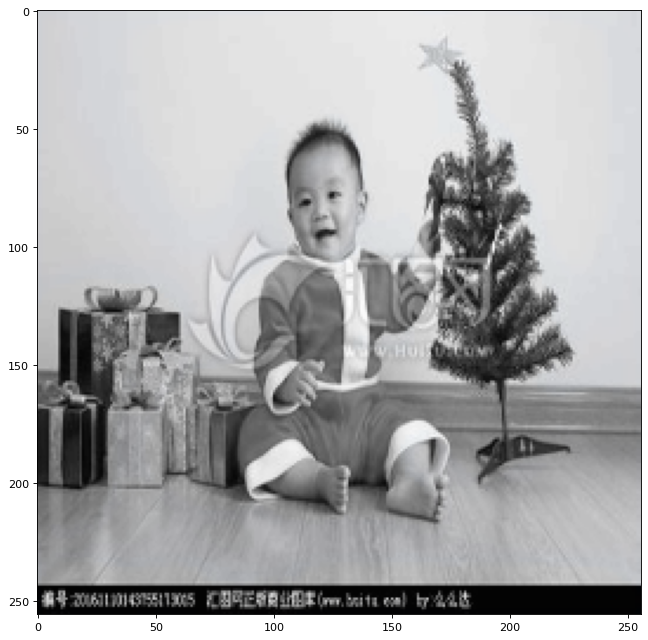

In [39]:
# Get images
file_paths = glob('./*/*.*g')
image = np.array(load_resize_normalized_lab(file_paths[5])).astype('uint8')

X = lab_l(image.copy())

X = np.array(X).reshape(1, 256, 256, 1)
# Output colorizations
output = generator.predict(X)

canvas = np.zeros((256, 256, 3))
canvas[:,:,0] = image[:,:,0]
canvas[:,:,1:] = output[0]

canvas = de_normalize_array(canvas)
canvas = cv2.resize(canvas, (image.shape[1], image.shape[0]))

img = color.lab2rgb(canvas)
img = de_normalize_array(img)
imgbrg = img.copy()
imgbrg[:,:,0] = img[:,:,2]
imgbrg[:,:,1] = img[:,:,1]
imgbrg[:,:,2] = img[:,:,0]

from matplotlib.pyplot import figure

figure(figsize=(10, 10), dpi=80)

plt.imshow(imgbrg)
plt.show()
#cv2.imsave("img_result.png", color.lab2rgb(canvas))
#cv2.imsave("img_gray_scale.png", color.rgb2gray(lab2rgb(canvas)))

# No GAN